# **Projeto**
O objetivo deste projeto é complementar o conhecimento técnico obtido ao longo desta disciplina em um projeto de engenharia e análise de dados que envolve ingestão, armazenamento e análise de dados. A seguir uma breve descrição dos tópicos que serão abordados:



1.   Ingestão de dados: Construir uma aplicação que ingere dados do CoinMarketCap, os transforma e os carrega em um armazenamento de dados.
2.   Modelagem de dados e design de banco de dados: Construa um modelo de dados e projete um esquema de banco de dados para o armazenamento.
3.   Análise de dados: Crie gráficos que apresentem:
O preço do Bitcoin nos últimos 5 anos. Utilize a figura 1 como exemplo.
Gráfico do tipo candlestick nos últimos 30 dias do Bitcoin. Utilize a figura 2 como exemplo.


1. Ingestão de dados e Modelagem de dados

# Criar conexão no banco de dados e inicia o panda e mysql utilizando o ORM PonyORM

In [ ]:
# Instala pacotes para utilização do PonyORM
!pip install pony
!pip install mysqlclient
!pip install pymysql
!pip install mplfinance

In [ ]:
# Importar os pacotes para atender o projeto

# Importa os pacotes do PonyORM
from pony.orm import *
from datetime import date
from datetime import datetime
from datetime import timedelta

#Recuperar os registros através da API
import requests
import io
import json

# Pacotes para gerar relatório e gráficos
import pandas as pd
import matplotlib.pyplot as plt

# Pacotes referente ao relatório candle
import yfinance as yf
import mplfinance as mpf

In [ ]:

db = Database()
db.bind(provider='mysql', host='#########.mysql.database.azure.com', user='###', passwd='####', db='mba_projeto_data_science')

# Cria os Models Coin e History para administrar os dados

class Coin(db.Entity):
    id = PrimaryKey(int, auto=True)
    symbol = Required(str , unique=True)
    display_symbol = Optional(str)
    name = Optional(str)
    shortname = Optional(str)
    last_price_usd = Optional(float)
    last_date_updated = Optional(date)
    history = Set("History")
    history_candle = Set("HistoryCandle")

class History(db.Entity):
    id = PrimaryKey(int, auto=True)
    coin_id = Required(Coin, reverse="history")
    coin_price = Optional(float)
    date_price = Optional(date)

class HistoryCandle(db.Entity):
    id = PrimaryKey(int, auto=True)
    coin_id = Required(Coin, reverse="history_candle")
    date = Required(date)
    open = Optional(float)
    high = Optional(float)
    low = Optional(float)
    close = Optional(float)
    volume = Optional(float)


# cria as tabelas no banco de dados caso elas não existirem
db.generate_mapping(create_tables=True)

def insert_or_update_coin(symbol=None, display_symbol=None, name=None, shortname=None, last_price_usd=None, last_date_updated=None):
    with db_session:
        coin = Coin.get(symbol=symbol)
        if coin:
            coin.last_price_usd = last_price_usd
        else:
            coin = Coin( symbol=symbol, display_symbol=display_symbol , name=name , shortname=shortname , last_price_usd=last_price_usd , last_date_updated=last_date_updated )
    return coin

def update_last_date_coin(symbol=None, last_date_updated=None):
    with db_session:
        coin = Coin.get(symbol=symbol)
        if coin:
            coin.last_date_updated = last_date_updated
    return coin

def insert_or_update_history(coin, date_price, coin_price) :
    with db_session:
        history = History.get(coin_id=coin.id , date_price=date_price)
        if history:
            history.coin_price = coin_price
        else:
            history = History( coin_id=coin.id, date_price=date_price , coin_price=coin_price )
    return history

def get_history_all():
  with db_session:
    history = select(p for p in History)
    data = [(history.date_price, history.coin_price) for history in history]
    return data

def insert_or_update_history_candle(bitcoin_data) :
    with db_session:
      for index, btc_row in bitcoin_data.iterrows():
        if index == 0:
          continue  # Skip the header row
        history_candle = HistoryCandle.get(coin_id=coin.id , date=index.date())
        if history_candle:
            history_candle.open = btc_row.Open
            history_candle.high = btc_row.High
            history_candle.low = btc_row.Low
            history_candle.close = btc_row.Close
            history_candle.volume = btc_row.Volume
        else:
            history_candle = HistoryCandle( coin_id=coin.id, date=index.date() , open=btc_row.Open , high=btc_row.High , low=btc_row.Low , close=btc_row.Close , volume=btc_row.Volume )

def get_history_candle_all(start_date):
  with db_session:
    # return select(bp for bp in HistoryCandle if bp.date >= start_date).order_by(HistoryCandle.date)[:]
    registros = select(bp for bp in HistoryCandle if bp.date >= start_date).order_by(HistoryCandle.date)
    data = [(history.date, history.open, history.high, history.low, history.close, history.volume) for history in registros]
    return data



# Ler API das moedas, e para cada registro lido inserir/atualizar valores da moeda

In [ ]:

def buscar_dados():
    return requests.get("https://coincodex.com/apps/coincodex/cache/all_coins.json")

def buscar_valores_historico(symbol , data_inicio , data_final):
    return requests.get(f"https://coincodex.com/api/coincodex/get_coin_history/{symbol}/{data_inicio}/{data_final}")

arrayUrlData = buscar_dados().content
# arrayUrlData = urlData.decode('utf-8')
data = json.loads(arrayUrlData)

# Inclui moedas e atualiza a
i = 0
while i < len(data):

  #Para cada registro lido, inserir o registro no banco de dados, se já existir, então atualizar o registro
  # Por questão didática, criar registros somente no Bitcoin, caso tiver necessidade podera colocar outras moedas aqui
  if data[i]['symbol'] == 'BTC' :
    print(data[i])
    # Convert datetime string to date
    datetime_obj = datetime.strptime(data[i]['trading_since'], "%Y-%m-%d %H:%M:%S")
    date_obj = datetime_obj.date()
    coin_row = insert_or_update_coin(symbol=data[i]['symbol'], display_symbol=data[i]['display_symbol'], name=data[i]['name'], shortname=data[i]['shortname'], last_price_usd=data[i]['last_price_usd'], last_date_updated=date_obj)

  i += 1


# Atualiza os valores do historico

# Recupera a moeda
coin = Coin.get(symbol='BTC')
current_date = date.today()

arrayUrlDataValores = buscar_valores_historico('BTC', coin.last_date_updated , current_date).content
# arrayUrlDataValores = buscar_valores_historico('BTC', '2023-08-01' , current_date).content
data = json.loads(arrayUrlDataValores)
print(data['BTC'])

# Inclui moedas e atualiza o valor
i = 0
while i < 3:
  print(data['BTC'][i])
  # Convert Unix timestamp to datetime
  datetime_obj = datetime.fromtimestamp(data['BTC'][i][0])
  # # Extract the date component
  date_obj = datetime_obj.date()
  print(date_obj)
  i += 1

for historico in data['BTC'] :
  datetime_obj = datetime.fromtimestamp(historico[0])
  date_obj = datetime_obj.date()
  valor = historico[1]
  insert_or_update_history(coin, date_obj, valor)

# Insere a atualiza os valores para gerar o relatório candle
bitcoin_data = yf.download("BTC-USD", start=coin.last_date_updated, end=current_date)
print(bitcoin_data)
insert_or_update_history_candle(bitcoin_data)

# Atualiza a última data atualizada da moeda
coin_row = update_last_date_coin(symbol='BTC' , last_date_updated=current_date)



{'symbol': 'BTC', 'display_symbol': 'BTC', 'name': 'Bitcoin', 'aliases': '', 'shortname': 'bitcoin', 'last_price_usd': 26022, 'market_cap_rank': 1, 'volume_rank': 2, 'price_change_1H_percent': -0.02, 'price_change_1D_percent': 0.13, 'price_change_7D_percent': -0.46, 'price_change_30D_percent': -11.27, 'price_change_90D_percent': -6.08, 'price_change_180D_percent': 12.39, 'price_change_365D_percent': 30.18, 'price_change_3Y_percent': 130, 'price_change_5Y_percent': 268, 'price_change_ALL_percent': 52043400, 'price_change_YTD_percent': 56.8, 'volume_24_usd': 22092201984, 'display': 'true', 'trading_since': '2010-07-17 00:00:00', 'supply': 19461531, 'last_update': '1693188171', 'ico_end': None, 'include_supply': 'true', 'use_volume': 'true', 'growth_all_time': '70.7946', 'ccu_slug': 'bitcoin', 'image_id': 'b9469e27-476b-4fc8-0d5e-9a9e51581400', 'image_t': 1654242883, 'market_cap_usd': 506423288915, 'categories': [1, 39]}
[[1693101600, 25997.71, 20227978931, 505955239094], [1693101900, 259

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: IndexError('index 0 is out of bounds for axis 0 with size 0')



Empty DataFrame
Columns: [Open, High, Low, Close, Adj Close, Volume]
Index: []


# Crie gráficos que apresentem: O preço do Bitcoin nos últimos 5 anos. Utilize a figura 1 como exemplo. Gráfico do tipo candlestick nos últimos 30 dias do Bitcoin. Utilize a figura 2 como exemplo.

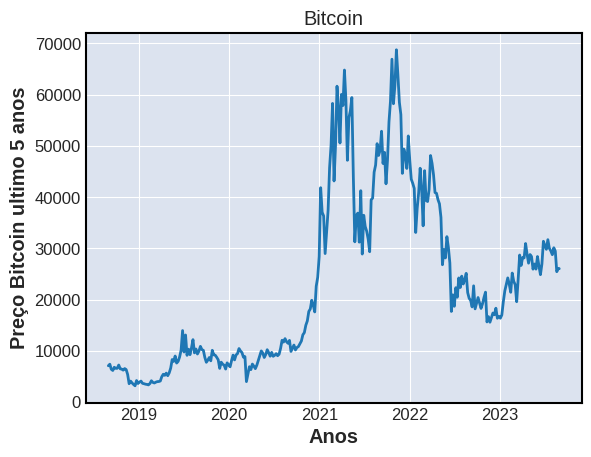

In [ ]:


# Convert the data to a pandas DataFrame
data = get_history_all()
df = pd.DataFrame(data, columns=["Date", "Valor"])

# Calculate the date 5 years ago from today
today = datetime.today()
five_years_ago = today - timedelta(days=5 * 365)

# Convert datetime to date for comparison
five_years_ago_date = five_years_ago.date()

# Filter data for the last 5 years
filtered_df = df[df["Date"] >= five_years_ago_date]

# Gráfico 1

plt.figure()
plt.plot(filtered_df['Date'], filtered_df['Valor'])
plt.xlabel('Anos')
plt.ylabel('Preço Bitcoin ultimo 5 anos')
plt.title('Bitcoin')
plt.grid(True)
plt.show()


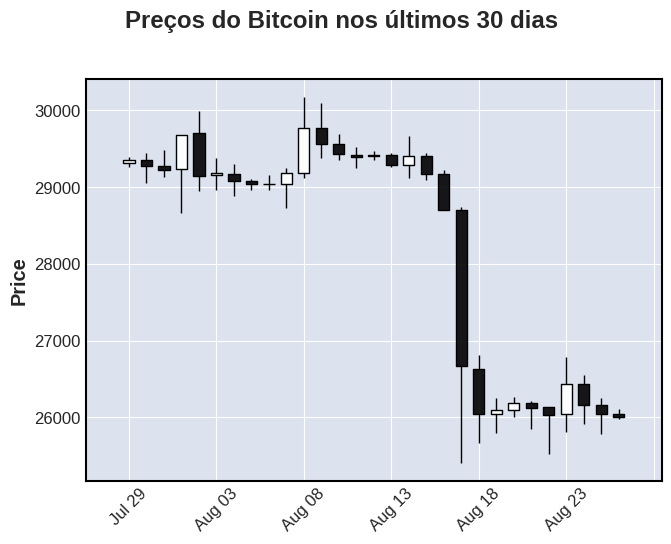

In [ ]:
# Gráfico 2

# Obtendo os dados do último mês do Bitcoin
end_date = datetime.today().date()
start_date = end_date - timedelta(days=30)
data = get_history_candle_all(start_date)
data

df = pd.DataFrame(data, columns=["Date", "Open", "High", "Low", "Close", "Volume"])

# Converter a coluna "date" para datetime
df["Date"] = pd.to_datetime(df["Date"])

# Defina o índice do DataFrame para a coluna "date"
df.set_index("Date", inplace=True)

# Criar o gráfico de candlestick
mpf.plot(df, type='candle', title="Preços do Bitcoin nos últimos 30 dias")
